# Motor Temperature Prediction

Importing necessary Libraries used in the code

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import RFE
from sklearn.ensemble import ExtraTreesRegressor

import warnings

-----------------

Importing Train data file of the Kaggle competition

In [2]:
data = pd.read_csv("train.csv")

Removing the index as it is not required for model building and predictions

In [3]:
data = data.drop(data.columns[0], axis=1)

------------

## Exoploratory Data Analysis

In [4]:
data.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
2,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
3,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4
4,-0.762936,-1.116955,0.334901,-1.303017,-1.222429,-0.248197,1.031031,-0.246341,-2.522203,-1.831931,-2.062549,-2.017884,4


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698649 entries, 0 to 698648
Data columns (total 13 columns):
ambient           698649 non-null float64
coolant           698649 non-null float64
u_d               698649 non-null float64
u_q               698649 non-null float64
motor_speed       698649 non-null float64
torque            698649 non-null float64
i_d               698649 non-null float64
i_q               698649 non-null float64
pm                698649 non-null float64
stator_yoke       698649 non-null float64
stator_tooth      698649 non-null float64
stator_winding    698649 non-null float64
profile_id        698649 non-null int64
dtypes: float64(12), int64(1)
memory usage: 69.3 MB


In [6]:
data.shape

(698649, 13)

In [7]:
data.isnull().sum()

ambient           0
coolant           0
u_d               0
u_q               0
motor_speed       0
torque            0
i_d               0
i_q               0
pm                0
stator_yoke       0
stator_tooth      0
stator_winding    0
profile_id        0
dtype: int64

In [8]:
data.describe()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
count,698649.000000,698649.000000,698649.000000,698649.000000,698649.000000,698649.000000,698649.000000,698649.000000,698649.000000,698649.000000,698649.000000,698649.000000,698649.000000
mean,-0.003129,0.004779,0.004275,-0.005819,-0.006024,-0.002985,0.005794,-0.002809,-0.004385,0.000623,-0.002212,-0.003988,50.737721
std,0.992710,1.002086,0.997729,1.002404,1.001700,0.997403,0.999005,0.997375,0.995450,1.001119,0.999732,0.998443,22.072923
min,-7.968341,-1.367800,-1.654878,-1.861463,-1.371529,-3.345953,-3.245874,-3.341639,-2.631991,-1.834688,-2.066143,-2.019973,4.000000
25%,-0.598182,-1.037856,-0.827631,-0.927994,-0.951892,-0.266604,-0.756753,-0.257268,-0.671621,-0.747074,-0.761951,-0.725651,32.000000
50%,0.266325,-0.176651,0.267501,-0.099512,-0.140246,-0.187167,0.213188,-0.188490,0.094138,-0.057264,0.005240,0.006893,56.000000
75%,0.686697,0.648482,0.358460,0.852677,0.855411,0.547458,1.013975,0.499623,0.680431,0.697432,0.772349,0.725208,68.000000
max,2.967117,2.649032,2.274734,1.793498,2.024151,3.016895,1.060937,2.914185,2.917456,2.449158,2.326668,2.651810,81.000000


Histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000E6E7388>,
      dtype=object)

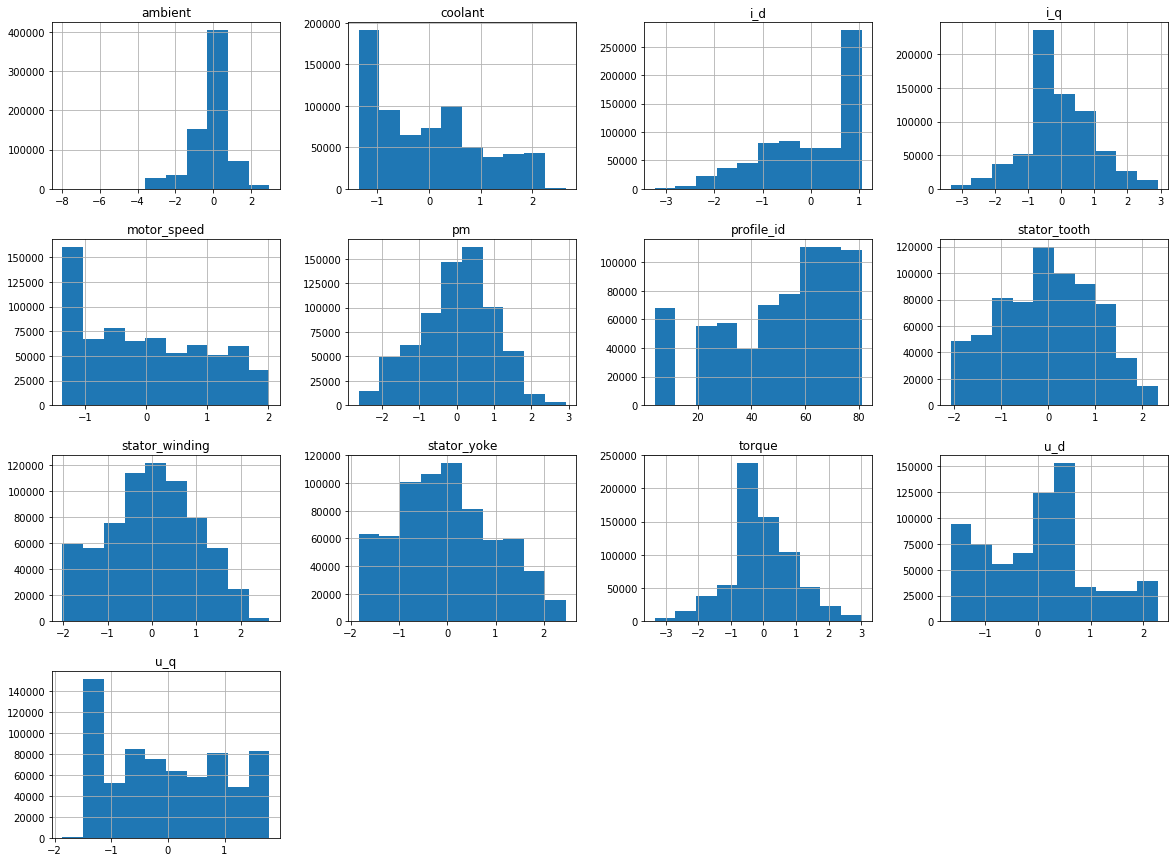

In [9]:
data.hist(figsize=(20,15))

Correlation Matrix with Heatmap

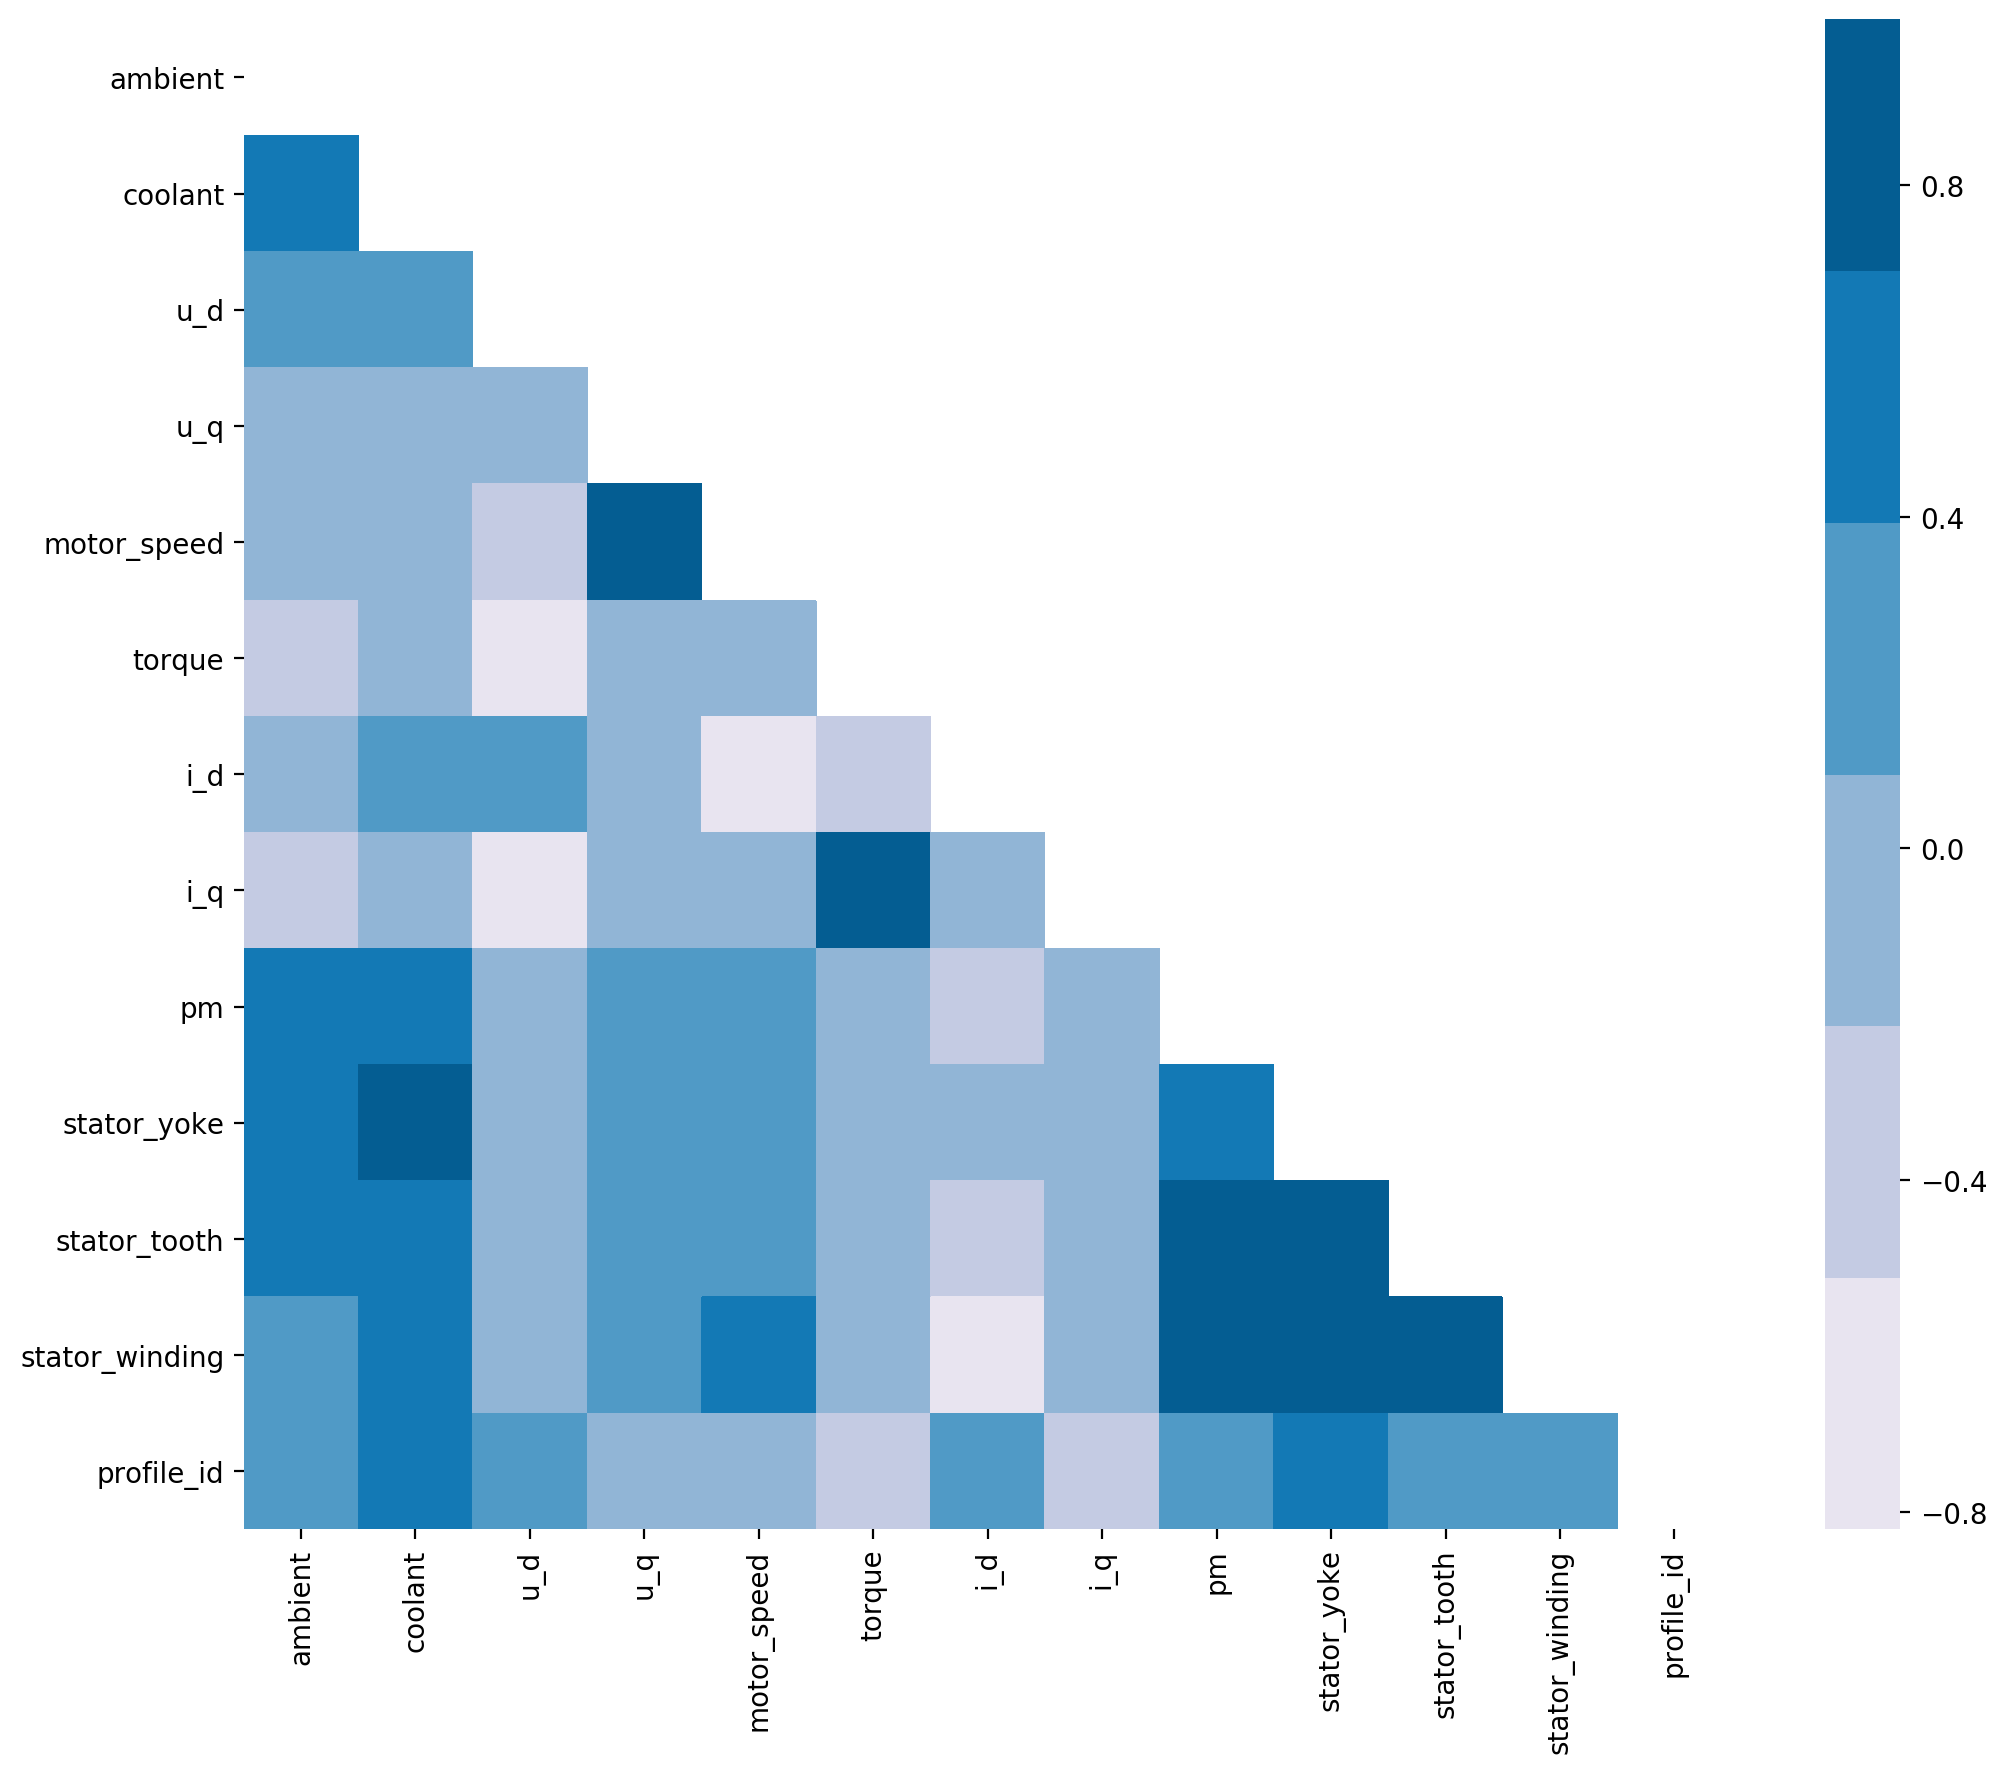

In [10]:
corr = data.corr()
plt.figure(figsize = (12, 10), dpi = 200)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(corr, mask = mask, annot = False, cbar = True, cmap = sns.color_palette('PuBu'))

Boxplot

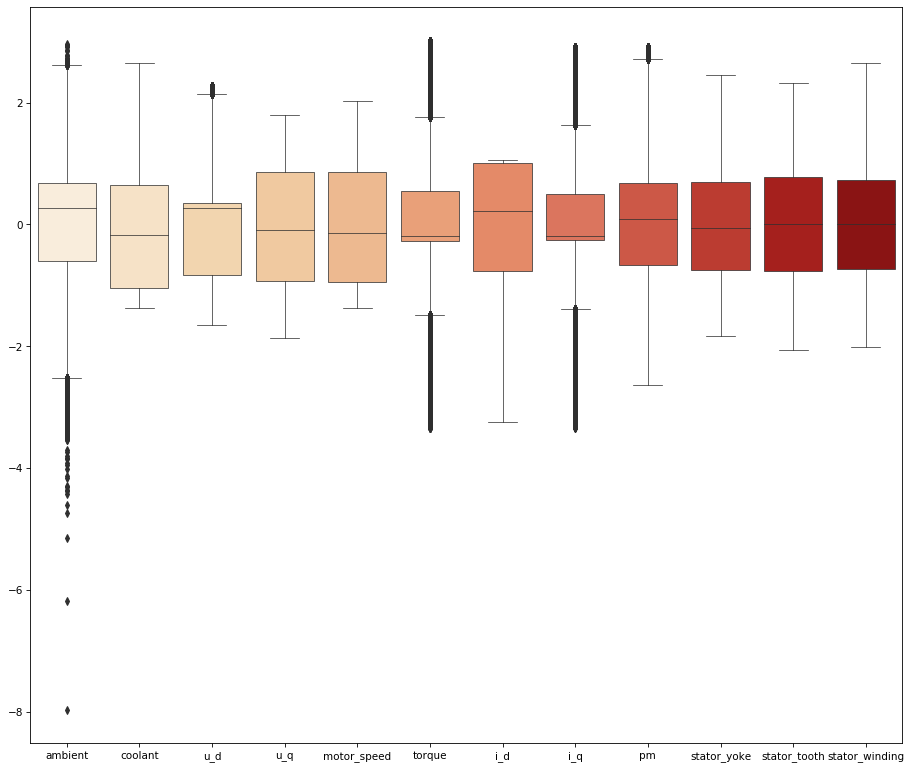

In [11]:
plt.figure(figsize = (15, 13), dpi = 75)
sns.boxplot(data = data[data.columns[:12]], palette = 'OrRd', linewidth = 0.7)

Detecting Outliers

In [12]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).sum()

ambient            26915
coolant                0
u_d                12453
u_q                    0
motor_speed            0
torque             89097
i_d                    0
i_q               103797
pm                  1063
stator_yoke            0
stator_tooth           0
stator_winding         0
profile_id             0
dtype: int64

Removing Outliers

In [13]:
data_without_outliers = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
data_without_outliers.shape

(570755, 13)

Boxplot without Outliers

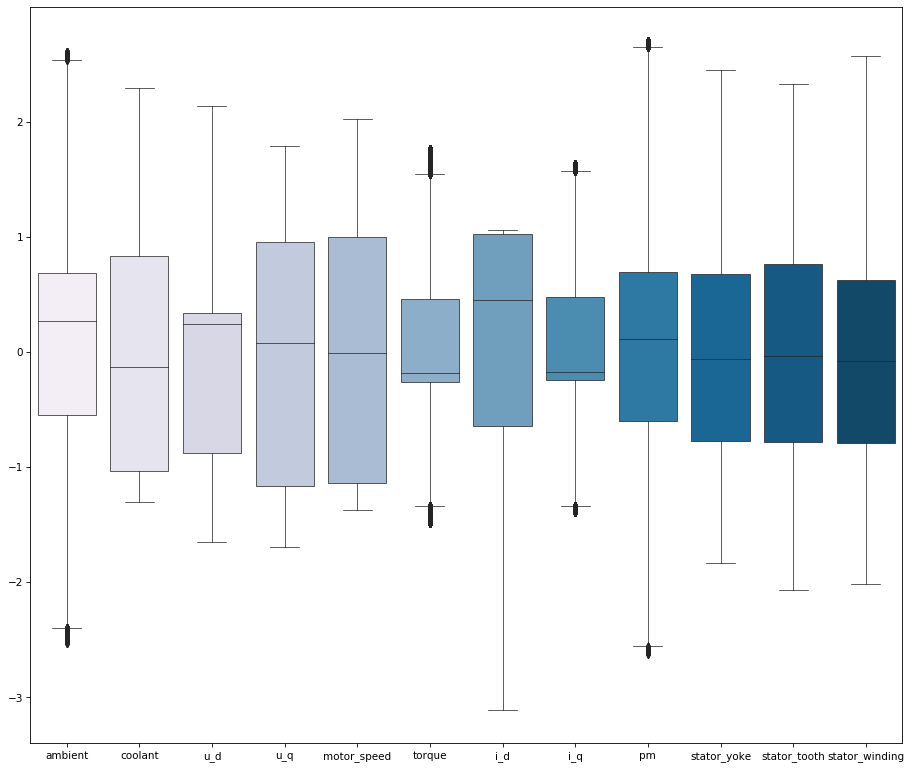

In [14]:
plt.figure(figsize = (15, 13), dpi = 75)
sns.boxplot(data = data_without_outliers[data_without_outliers.columns[:12]], palette = 'PuBu', linewidth = 0.7)

------------------

Assigning Independent and Dependent Variables to x and y

In [15]:
x = data.iloc[:,[0,1,2,3,4,5,6,7,9,10,11,12]]

In [16]:
y = data["pm"]

-----------------

## Model Building

--------------

In [17]:
model = ExtraTreesRegressor(n_estimators = 200)

In [18]:
rfe = RFE(model, 5)
fit = rfe.fit(x, y)

In [19]:
print("Number of Features selected ->", fit.n_features_)
print("Selected Features ->", fit.support_)
print("Feature Ranking ->", fit.ranking_)

Number of Features selected -> 5
Selected Features -> [ True False False False False False False False  True  True  True  True]
Feature Ranking -> [1 3 8 5 2 6 7 4 1 1 1 1]


Creating a Pickle File for further usage

In [ ]:
#joblib_file = "etr_model.pkl"
#with open(joblib_file, 'wb') as file:
#    joblib.dump(rfe, file, compress = 9)

Splitting the whole data into Train and Test set

In [20]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

Predicting the testset

In [21]:
pred = rfe.predict(X_test)

Calculating the Root Mean Squared Error

In [22]:
rmse = np.sqrt(mean_squared_error(y_test, pred))
print(rmse)

7.707986192397071e-05


--------------

Importing Test data file of Kaggle competition

In [23]:
test_set = pd.read_csv("test.csv")

In [24]:
test_data = test_set[test_set.columns[1:13]]

Predicting Test Target Variable

In [25]:
etr_test_pred = rfe.predict(test_data)

Making sure that the index value starts from 1

In [26]:
test_pred = pd.DataFrame(etr_test_pred)
test_pred.index += 1

Exporting the Predicted values to a CSV file to upload into Kaggle

In [27]:
test_pred.to_csv("test_predictions.csv", index = True, index_label="Id", header = ["prediction1"])